In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import statsmodels.api as sm
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline

In [355]:
data = pd.read_csv('electricity.csv')

In [356]:
data.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


In [357]:
data.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5515,5515,4410.631913,14.70,5515,43,187
5516,5516,4292.029885,14.60,5516,44,188
5517,5517,4231.380523,14.65,5517,45,189
5518,5518,4587.536047,14.70,5518,46,190
5519,5519,4540.230041,14.75,5519,47,191


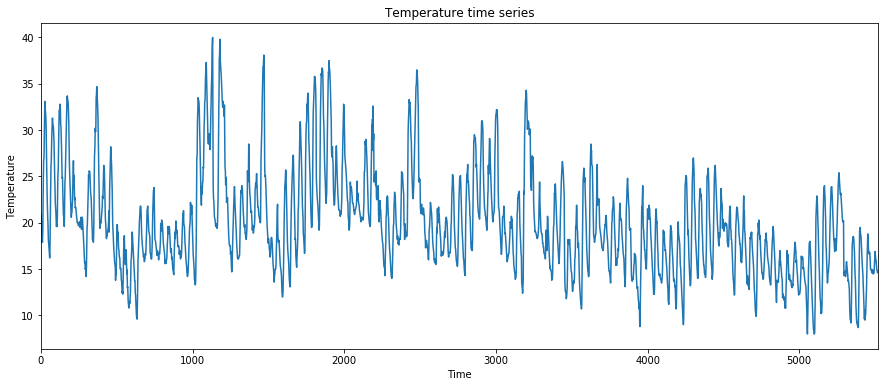

In [358]:
t = data['Temperature']
t.plot(figsize=(15, 6))

plt.title('Temperature time series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

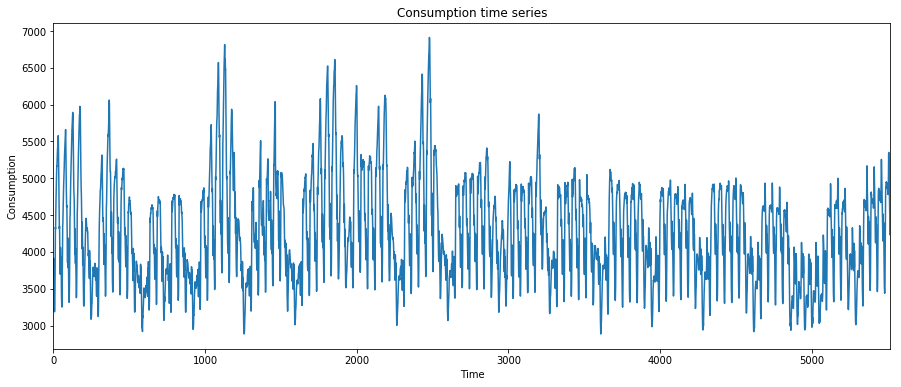

In [359]:
c = data['Consumption']
c.plot(figsize=(15, 6))

plt.title('Consumption time series')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

Проверим, зависит ли спрос на электричество от температуры воздуха. Для этого посчитаем их корреляцию. Применим критерии Спирмена и Кендалла. Критерий Пирсона применять не будем, так как нет никакой гарантии, что элементы выборки подчиняются нормальному закону.

In [360]:
print(sps.spearmanr(t, c))
print(sps.kendalltau(t, c))

SpearmanrResult(correlation=0.57805418606949333, pvalue=0.0)
KendalltauResult(correlation=0.41337814259124334, pvalue=0.0)


Видим, что pvalue в обоих случаях ноль. Получается, что мы отвергаем гипотезу 'Выборки некоррелированы'.  
Итак, спрос на электричество зависит от температуры.

In [361]:
train = data[:-48*7]
test = data[-48*7:]

In [362]:
train.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


In [363]:
train.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5179,5179,4131.878165,16.65,5179,43,187
5180,5180,4023.872303,16.10,5180,44,188
5181,5181,3968.512667,15.65,5181,45,189
5182,5182,4330.536516,15.20,5182,46,190
5183,5183,4317.386273,14.75,5183,47,191


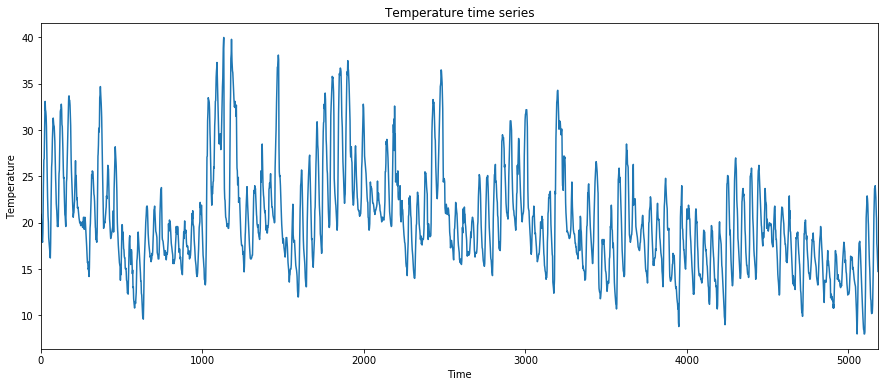

In [364]:
t = train['Temperature']
t.plot(figsize=(15, 6))

plt.title('Temperature time series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

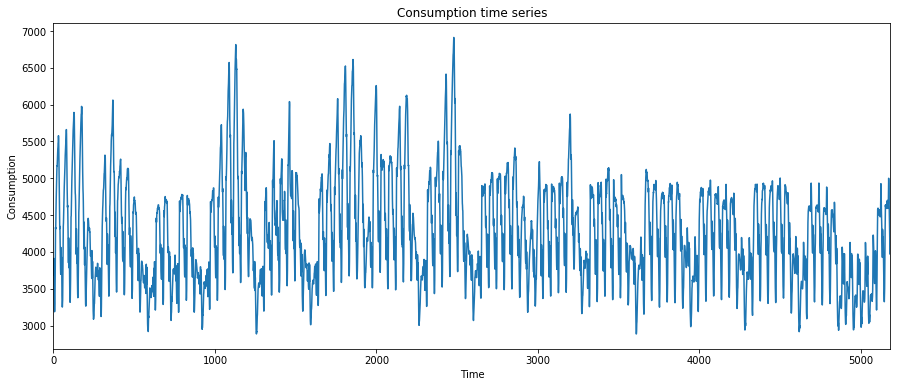

In [365]:
c = train['Consumption']
c.plot(figsize=(15, 6))

plt.title('Consumption time series')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

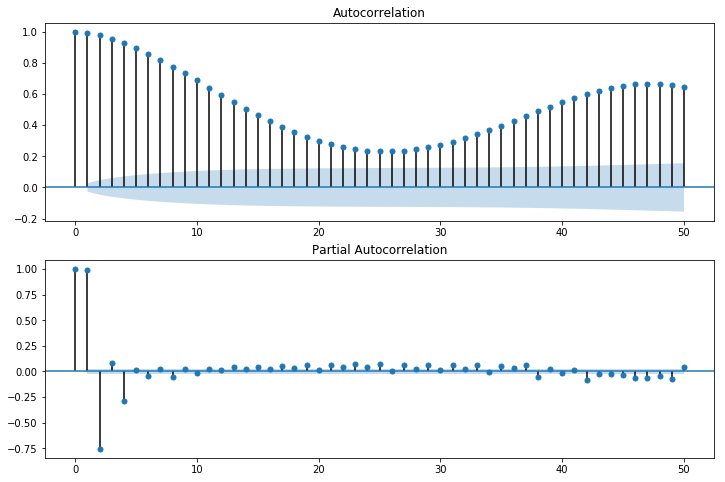

In [366]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(t, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(t, lags=50, ax=ax2)
plt.show()

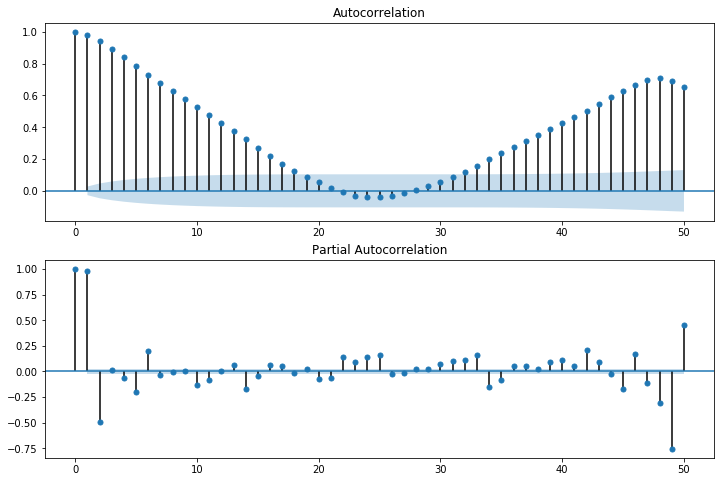

In [367]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(c, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(c, lags=50, ax=ax2)
plt.show()

In [368]:
T = np.array(t)
C = np.array(c)

Проанализировав таблицу приходим к выводу, что стоит ожидать наличие трех сезонностей. Ниже написана функция, которая убирает сезонности, а потом выводит каждую из них, тренд и остатки.  
Из графиков будет понятно, что сезонностей действительно три: значения будут сравнимы со значениями самой выборки.

In [381]:
def treatment(data):
    res = seasonal_decompose(data, freq=48)
    seasonal1 = res.seasonal

    d1data = data - seasonal1
    res = seasonal_decompose(d1data, freq=48*7)
    seasonal2 = res.seasonal

    d2data = d1data - seasonal2
    res = seasonal_decompose(d2data, freq=48*28)
    seasonal3 = res.seasonal

    trend = res.trend
    resid = res.resid
    
    fig = plt.figure(figsize=(12, 20))
    ax1 = fig.add_subplot(511)
    ax2 = fig.add_subplot(512)
    ax3 = fig.add_subplot(513)
    ax4 = fig.add_subplot(514)
    ax5 = fig.add_subplot(515)
    ax1.set_title('Trend')
    ax2.set_title('Daily seasonality')
    ax3.set_title('Weekly seasonality')
    ax4.set_title('Monthly seasonality')
    ax5.set_title('Residue')
    ax1.plot(trend)
    ax2.plot(seasonal1)
    ax3.plot(seasonal2)
    ax4.plot(seasonal3)
    ax5.plot(resid)
    plt.show()
    
    return resid[~np.isnan(resid)]

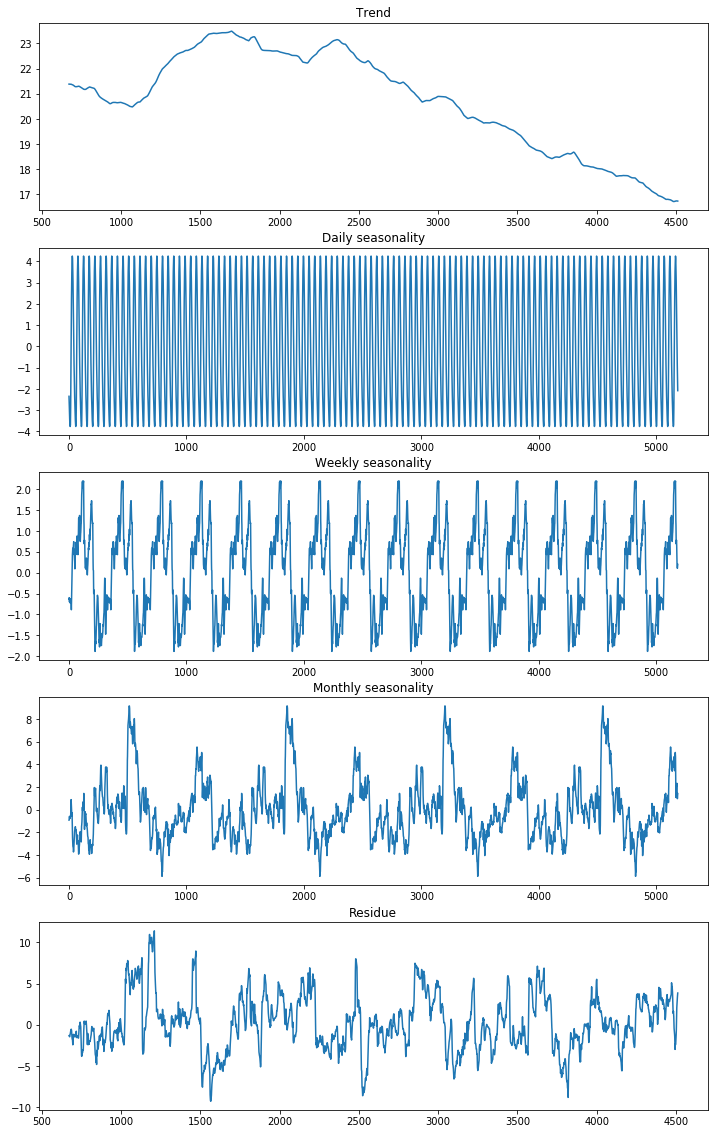

In [382]:
TEMP = treatment(T)

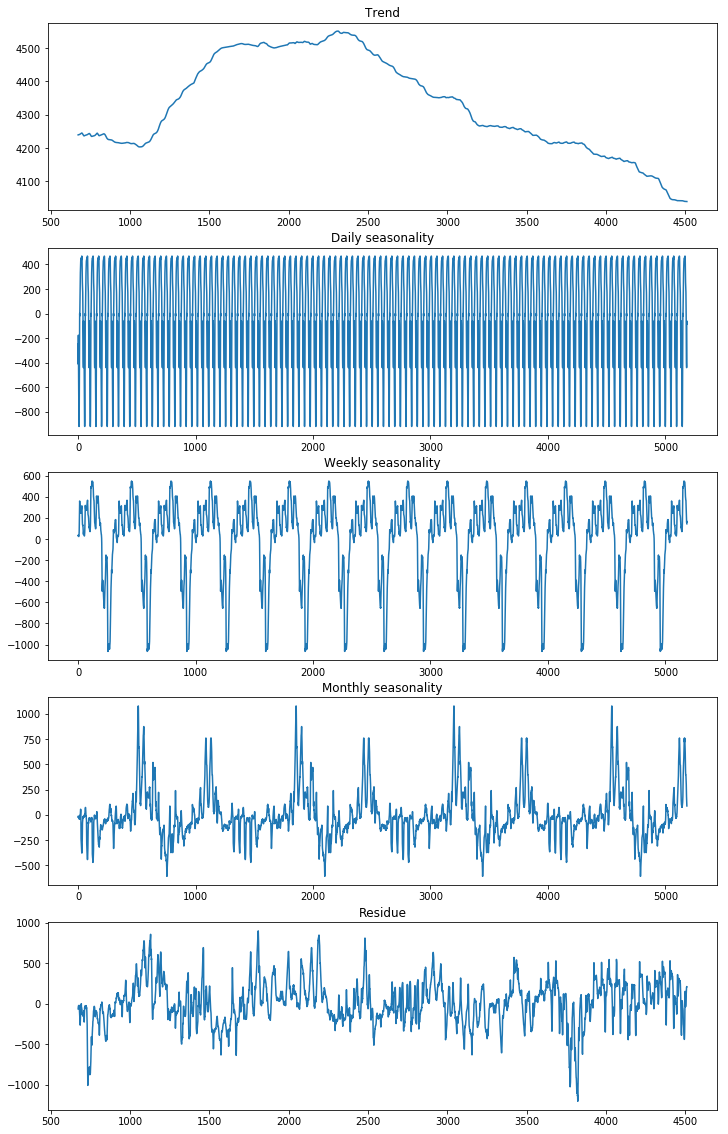

In [383]:
CONSUMPTION = treatment(C)

Посмотрим, что там со стационарностью. Хотелось бы, чтобы начальные данные были не стационарными (иначе все дальнейшее было зря), а преобразованные - стационарными (чтобы дальнейшее имело смысл).  
Посчитаем критерий KPSS и передадим это все функции для множественной проверки гипотез.

In [384]:
pvalues = np.array([kpss(T)[1], kpss(TEMP)[1], kpss(C)[1], kpss(CONSUMPTION)[1]])
res = multipletests(pvalues, method='bonferroni')
print("Гипотеза отклоняется:", res[0])
print("Скорректированные p-values:",res[1])

Гипотеза отклоняется: [ True False  True False]
Скорректированные p-values: [ 0.04  0.4   0.04  0.4 ]


Получили все, что хотели.  
Продолжаем.

Посмотрев на коррелограмму и график автокорреляционной функции понимаем, что все ОК - теперь все действительно стационарно.  

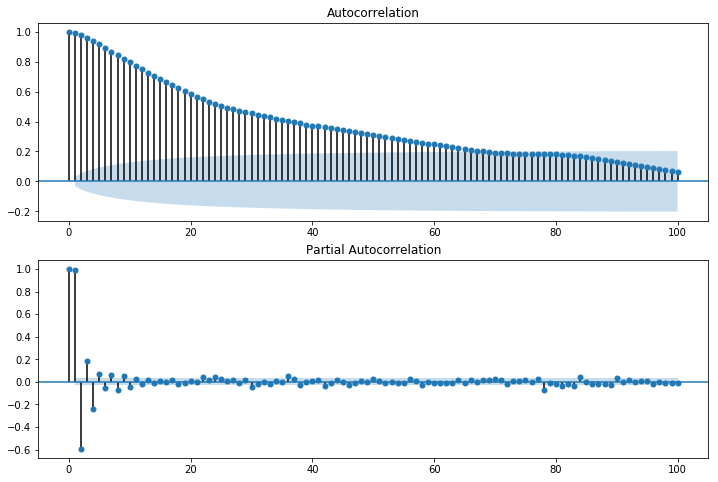

In [385]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(TEMP, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(TEMP, lags=100, ax=ax2)
plt.show()

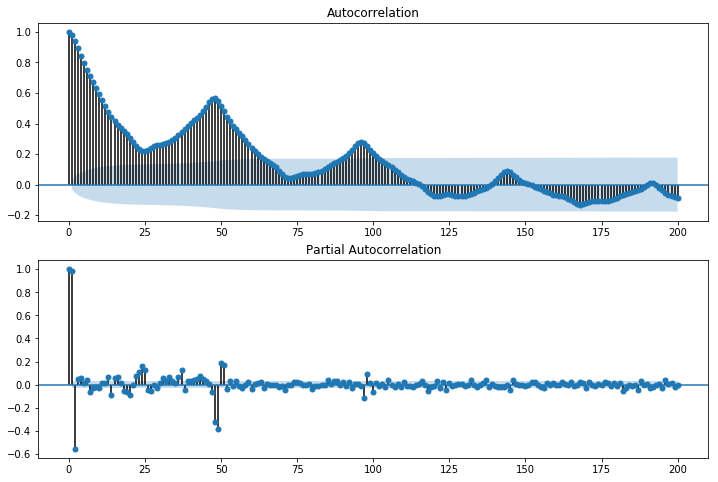

In [386]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CONSUMPTION, lags=200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CONSUMPTION, lags=200, ax=ax2)
plt.show()

Начинаем работать с температурой. Усредним данные (каждые 4 записи объединим в одну; в конце работы я поясню, зачем это надо, почему без этого плохо). 

In [387]:
T = T.reshape(-1, 4)
T = T.mean(axis=-1)

Проведем сезонное дифференцирование (период - неделя) и обычное. Первое уберет сезонность (но м.б. остались еще какие-то, пока непонятно), а второе - уберет тренд.

In [388]:
startT84 = T[:84]
T84 = T[84:] - T[:-84]
startT841 = T84[:1]
T841 = T84[1:] - T84[:-1]

Смотрим на графики и понимаем, что теперь имеем дело со стационарным рядом. Теперь по графикам подберем параметы модели SARIMAX.  
Графики построим для разного числа лагов, чтобы было удобно определять параметры.

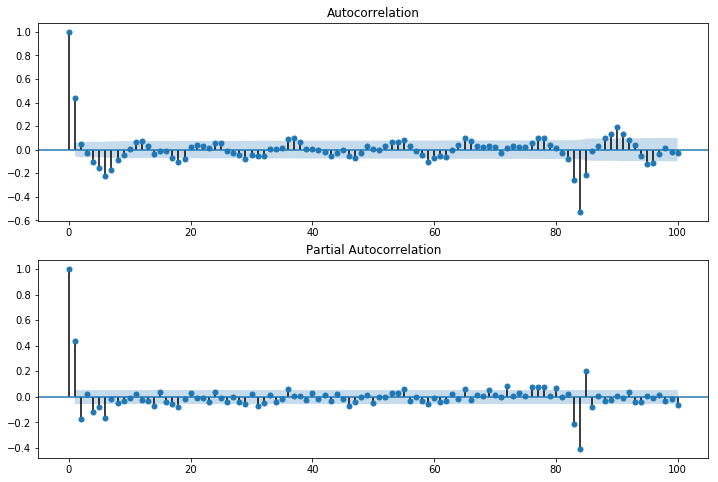

In [389]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(T841, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(T841, lags=100, ax=ax2)
plt.show()

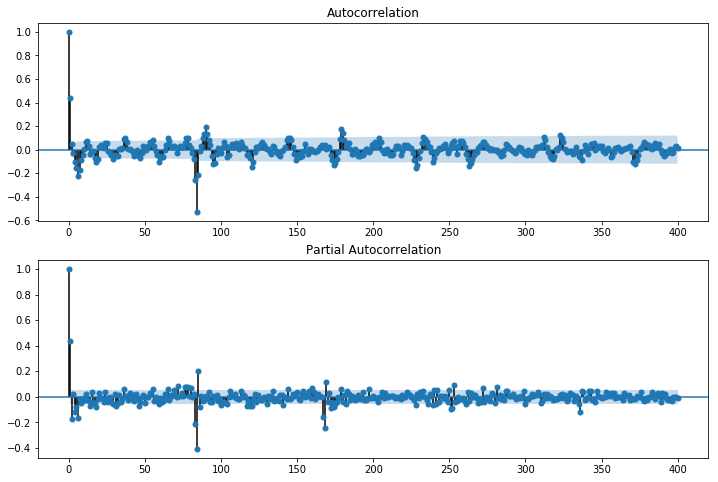

In [390]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(T841, lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(T841, lags=400, ax=ax2)
plt.show()

Параметры подбираются так: dD - число обычных и сезонных дифференцирований; pP - число несезонных и сезонных значимых лагов на графике автокорреляционной функции; qQ - число несезонных т сезонных значимых лагов на коррелограмме.

In [200]:
p = [0, 1, 2]
q = [0, 1]
d = [1]
P = [0, 1, 2]
D = [1]
Q = [0, 1, 2]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [201]:
warnings.filterwarnings('ignore')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(T841, order=param,
                                              seasonal_order=param_seasonal, 
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 – AIC:4986.724017730905
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 – AIC:4938.666645688364
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 – AIC:5368.463064009021
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 – AIC:4988.00326841277
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 – AIC:4940.635142757618
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 – AIC:5173.1964816156005
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 – AIC:4942.026446832588
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 – AIC:4938.779293114788
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 – AIC:5618.5360597938225
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 – AIC:4906.717838457176
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 – AIC:4858.837726402231
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 – AIC:5260.87908987905
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 – AIC:4904.60730578577
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 – AIC:4860.741345988053
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 – AIC:5070.957002912816
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 – AIC:4864.2580150082085
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 – AIC:4857.940950214287
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 – AIC:5709.649335291689
ARIMA(1, 1

Наименьший AIC получаем для ARIMA(2, 1, 1)x(2, 1, 2, 12).  
Продолжим работу с ней.

In [306]:
model = sm.tsa.statespace.SARIMAX(T841, order=(2, 1, 1),
                                  seasonal_order=(2, 1, 2, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5180      0.023     22.157      0.000       0.472       0.564
ar.L2         -0.1766      0.025     -7.086      0.000      -0.225      -0.128
ma.L1         -1.0000     17.568     -0.057      0.955     -35.432      33.432
ar.S.L12      -0.4247      0.376     -1.131      0.258      -1.161       0.311
ar.S.L24       0.0110      0.024      0.451      0.652      -0.037       0.059
ma.S.L12      -0.5451     46.313     -0.012      0.991     -91.316      90.226
ma.S.L24      -0.4550     21.015     -0.022      0.983     -41.643      40.733
sigma2         2.6228    129.569      0.020      0.984    -251.328     256.574


In [307]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1211
Model:             SARIMAX(2, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -2257.628
Date:                            Fri, 08 Dec 2017   AIC                           4531.256
Time:                                    22:11:36   BIC                           4572.049
Sample:                                         0   HQIC                          4546.615
                                           - 1211                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5180      0.023     22.157      0.000       0.472       0.564
ar.L2         -0.1766      0.025     -7.086      0.000      -0.225      -0.128
ma.L1         -1.0000     17.568     -0.057      0.955     -35.432      33.432
ar.S.L12      -0.4247      0.376     -1.131      0.258      -1.161       0.311
ar.S.L24       0.0110      0.024      0.451      0.652      -0.037       0.059
ma.S.L12      -0.5451     46.313     -0.012      0.991     -91.316      90.226
ma.S.L24      -0.4550     21.015     -0.022      0.983     -41.643      40.733
sigma2         2.6228    129.569      0.020      0.984    -251.328     256.574
===================================================================================
Ljung-Box (Q):                      113.96   Jarque-Bera (JB):               652.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

На графике в левом углу получили прямую, неплохо приближающую точки $\implies$ движемся в верном направлении.

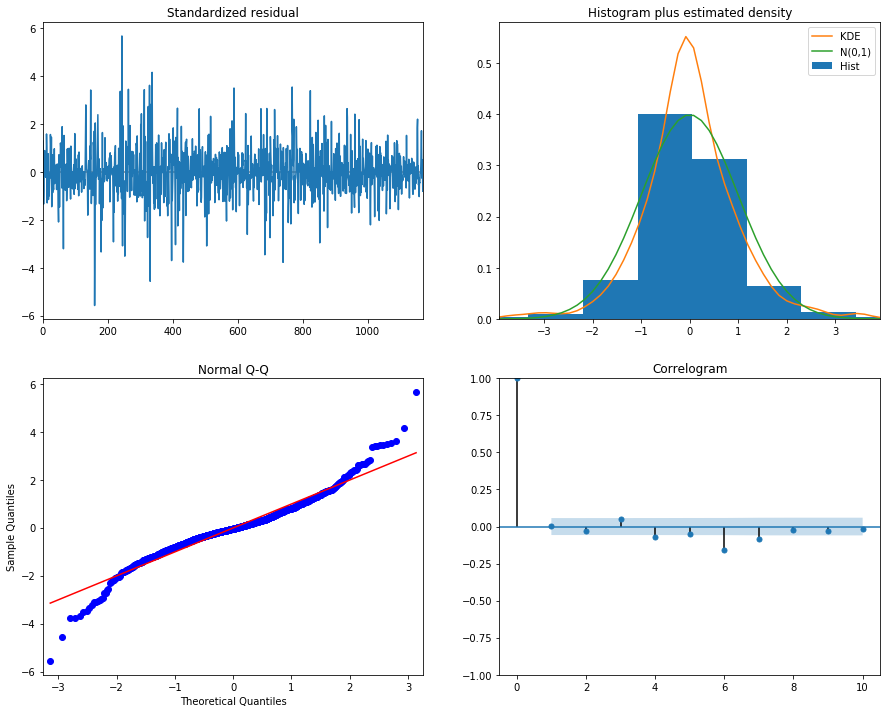

In [308]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Сделаем прогназ на неделю вперед (заметим, что неделя сейчас считается, как сжатая; потом разожмем).

In [309]:
pred_dynamic = model.get_prediction(start=1211, end=1294,
                                    dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Ряд был дифференцирован - пришло время склеить все воедино и вернуть естественные значения.

In [310]:
predict = pred_dynamic.predicted_mean

combine = T841
for t in range(84):
    combine = np.append(combine, combine[t - 84] + predict[t])
    
int1 = startT841
for t in range(1295):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startT84
for t in range(1296):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(1380):
    prediction[4 * i] = int2[i]
    prediction[4 * i + 1] = int2[i]
    prediction[4 * i + 2] = int2[i]
    prediction[4 * i + 3] = int2[i]

Посмотрим, что получилось.

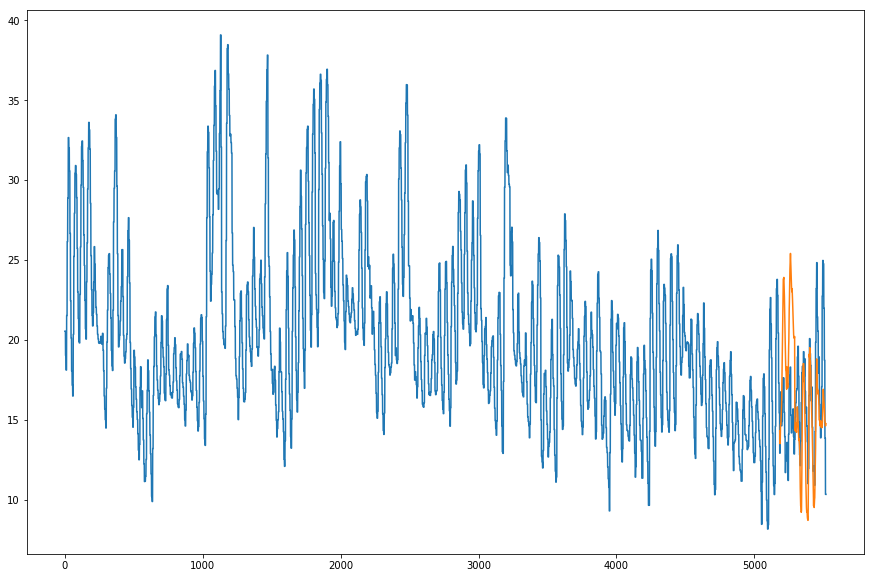

In [311]:
plt.figure(figsize=(15,10))
plt.plot(np.array(train.Temperature)[:-336], label='TRAIN')
plt.plot(prediction[:336], label='PREDICTION')
plt.plot(test.Temperature, label='TRUE')
plt.legend()
plt.show()

Посчитаем ошибку.

In [313]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Temperature)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 20.9


In [319]:
# Запомним, так как понадобится позднее.
PREDICTEDTEMPERATURE = prediction

Для потребления электричества проведем аналогичные действия. Единственное отличие - будем работать с данными, усредненными не по 4 записям, а по 2 (по 4 получалось как-то плохо, а по 2 более-менее нормально).

In [391]:
C = C.reshape(-1, 2)
C = C.mean(axis=-1)

In [392]:
startC84 = C[:168]
C84 = C[168:] - C[:-168]
startC841 = C84[:1]
C841 = C84[1:] - C84[:-1]

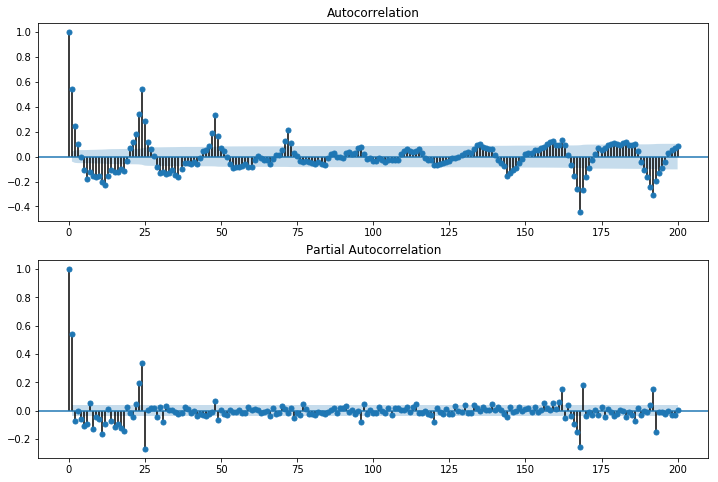

In [393]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(C841, lags=200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(C841, lags=200, ax=ax2)
plt.show()

In [227]:
p = [0, 1]
q = [0, 1, 2]
d = [1]
P = [0, 1]
D = [1]
Q = [0, 1, 2, 3]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(P, D, Q))]

In [228]:
warnings.filterwarnings('ignore')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(C841, order=param,
                                              seasonal_order=param_seasonal, 
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}24 – AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 1, 24)24 – AIC:28841.88894325014
ARIMA(0, 1, 0)x(0, 1, 2, 24)24 – AIC:28553.875568481733
ARIMA(0, 1, 0)x(0, 1, 3, 24)24 – AIC:28137.288246952812
ARIMA(0, 1, 0)x(1, 1, 0, 24)24 – AIC:28928.423148196245
ARIMA(0, 1, 0)x(1, 1, 1, 24)24 – AIC:28636.91155272293
ARIMA(0, 1, 0)x(1, 1, 2, 24)24 – AIC:28337.274436790693
ARIMA(0, 1, 0)x(1, 1, 3, 24)24 – AIC:28117.782154240354
ARIMA(0, 1, 1)x(0, 1, 0, 24)24 – AIC:29319.865618379918
ARIMA(0, 1, 1)x(0, 1, 1, 24)24 – AIC:28702.254250478036
ARIMA(0, 1, 1)x(0, 1, 2, 24)24 – AIC:28408.06563500317
ARIMA(0, 1, 1)x(0, 1, 3, 24)24 – AIC:28004.25568713924
ARIMA(0, 1, 1)x(1, 1, 0, 24)24 – AIC:28808.287444484224
ARIMA(0, 1, 1)x(1, 1, 1, 24)24 – AIC:28490.61234411704
ARIMA(0, 1, 1)x(1, 1, 2, 24)24 – AIC:28196.43837588526
ARIMA(0, 1, 1)x(1, 1, 3, 24)24 – AIC:27976.53449527741
ARIMA(0, 1, 2)x(0, 1, 0, 24)24 – AIC:28895.669576149936
ARIMA(0, 1, 2)x(0, 1, 1, 24)24 – AIC:28315.160286684404
ARIMA(0, 1, 2)x(0, 1, 2, 24)24 – AIC:28022.99509770888


In [229]:
model = sm.tsa.statespace.SARIMAX(C841, order=(1, 1, 2),
                                  seasonal_order=(0, 1, 3, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4448      0.030     14.893      0.000       0.386       0.503
ma.L1         -0.8800      0.069    -12.778      0.000      -1.015      -0.745
ma.L2         -0.1204      0.036     -3.352      0.001      -0.191      -0.050
ma.S.L24      -0.5573      0.010    -57.725      0.000      -0.576      -0.538
ma.S.L48      -0.2045      0.012    -17.154      0.000      -0.228      -0.181
ma.S.L72      -0.2129      0.011    -18.558      0.000      -0.235      -0.190
sigma2      7814.7517    573.675     13.622      0.000    6690.369    8939.134


In [230]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2423
Model:             SARIMAX(1, 1, 2)x(0, 1, 3, 24)   Log Likelihood              -13741.346
Date:                            Fri, 08 Dec 2017   AIC                          27496.692
Time:                                    21:39:33   BIC                          27537.241
Sample:                                         0   HQIC                         27511.437
                                           - 2423                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4448      0.030     14.893      0.000       0.386       0.503
ma.L1         -0.8800      0.069    -12.778      0.000      -1.015      -0.745
ma.L2         -0.1204      0.036     -3.352      0.001      -0.191      -0.050
ma.S.L24      -0.5573      0.010    -57.725      0.000      -0.576      -0.538
ma.S.L48      -0.2045      0.012    -17.154      0.000      -0.228      -0.181
ma.S.L72      -0.2129      0.011    -18.558      0.000      -0.235      -0.190
sigma2      7814.7517    573.675     13.622      0.000    6690.369    8939.134
===================================================================================
Ljung-Box (Q):                      191.21   Jarque-Bera (JB):             33065.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

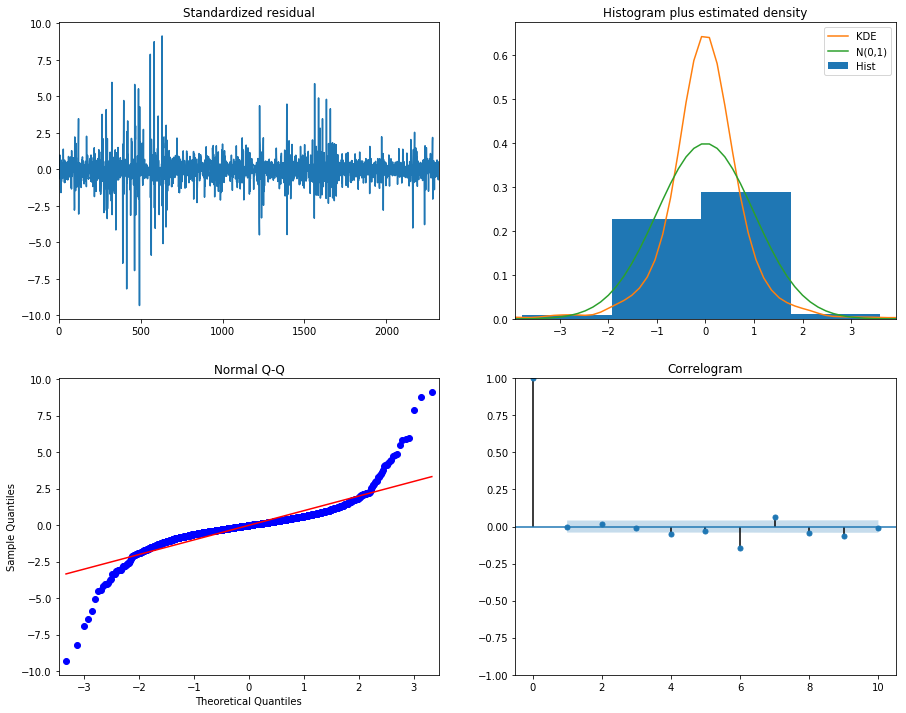

In [231]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [232]:
pred_dynamic = model.get_prediction(start=2423, end=2590,
                                    dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [233]:
predict = pred_dynamic.predicted_mean

combine = C841
for t in range(168):
    combine = np.append(combine, combine[t - 168] + predict[t])
    
int1 = startC841
for t in range(2591):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startC84
for t in range(2592):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(2760):
    prediction[2 * i] = int2[i]
    prediction[2 * i + 1] = int2[i]

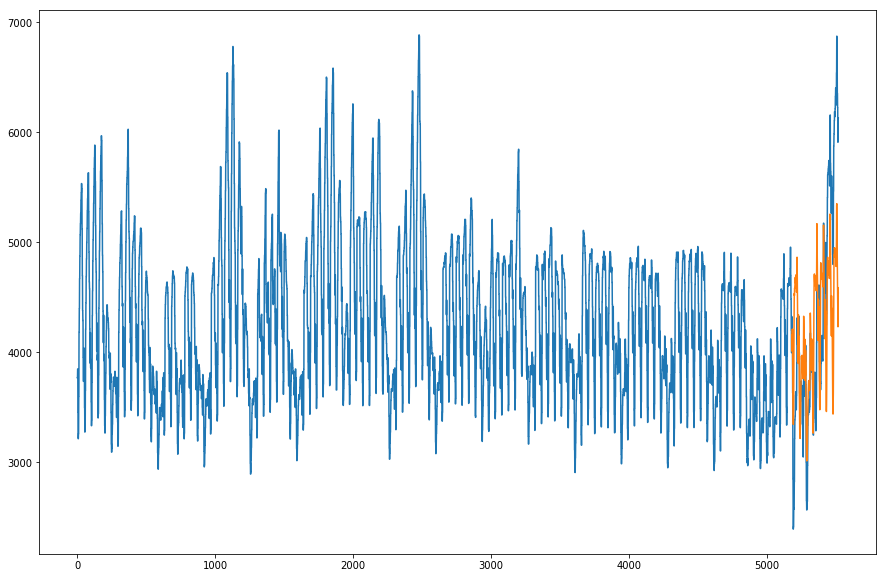

In [234]:
plt.figure(figsize=(15,10))
plt.plot(prediction)
plt.plot(test.Consumption)
plt.show()

In [235]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Consumption)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 650602.58


Теперь будем добавлять различные регрессоры.  
Основная идея следующая:
* Дополнительная информация так же делится на train и test
* В $SARIMAX$ идет то, что связано с train
* В $get\_prediction$ идет то, что связано с test

**Daily seasonality & weekly seasonality**

In [268]:
train_factor_1 = np.array(train.DailySeasonality)
train_factor_1 = train_factor_1.reshape(-1, 2)
train_factor_1 = train_factor_1.mean(axis=-1)
train_factor_1 = train_factor_1[169:]

train_factor_2 = np.array(train.WeeklySeasonality)
train_factor_2 = train_factor_2.reshape(-1, 2)
train_factor_2 = train_factor_2.mean(axis=-1)
train_factor_2 = train_factor_2[169:]

test_factor_1 = np.array(test.DailySeasonality)
test_factor_1 = test_factor_1.reshape(-1, 2)
test_factor_1 = test_factor_1.mean(axis=-1)

test_factor_2 = np.array(test.WeeklySeasonality)
test_factor_2 = test_factor_2.reshape(-1, 2)
test_factor_2 = test_factor_2.mean(axis=-1)

In [269]:
train_factor = np.vstack((train_factor_1, train_factor_2)).T
test_factor = np.vstack((test_factor_1, test_factor_2)).T

In [260]:
model = sm.tsa.statespace.SARIMAX(C841, order=(1, 1, 2),
                                  seasonal_order=(0, 1, 3, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False,
                                  exog=train_factor)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   6561.397    3.8e-08      1.000   -1.29e+04    1.29e+04
x2             0.0138      0.035      0.397      0.691      -0.054       0.082
ar.L1          0.4430      0.030     14.828      0.000       0.384       0.502
ma.L1         -0.8799      2.995     -0.294      0.769      -6.750       4.990
ma.L2         -0.1201      0.370     -0.324      0.746      -0.846       0.606
ma.S.L24      -0.5894      0.014    -41.761      0.000      -0.617      -0.562
ma.S.L48      -0.2196      0.013    -17.147      0.000      -0.245      -0.194
ma.S.L72      -0.2205      0.010    -21.459      0.000      -0.241      -0.200
sigma2      7530.6492   2.26e+04      0.333      0.739   -3.68e+04    5.19e+04


In [261]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2423
Model:             SARIMAX(1, 1, 2)x(0, 1, 3, 24)   Log Likelihood              -13741.293
Date:                            Fri, 08 Dec 2017   AIC                          27500.586
Time:                                    21:55:37   BIC                          27552.721
Sample:                                         0   HQIC                         27519.543
                                           - 2423                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   6561.397    3.8e-08      1.000   -1.29e+04    1.29e+04
x2             0.0138      0.035      0.397      0.691      -0.054       0.082
ar.L1          0.4430      0.030     14.828      0.000       0.384       0.502
ma.L1         -0.8799      2.995     -0.294      0.769      -6.750       4.990
ma.L2         -0.1201      0.370     -0.324      0.746      -0.846       0.606
ma.S.L24      -0.5894      0.014    -41.761      0.000      -0.617      -0.562
ma.S.L48      -0.2196      0.013    -17.147      0.000      -0.245      -0.194
ma.S.L72      -0.2205      0.010    -21.459      0.000      -0.241      -0.200
sigma2      7530.6492   2.26e+04      0.333      0.739   -3.68e+04    5.19e+04
===================================================================================
Ljung-Box (Q):                      191.06   Jarque-Bera (JB):             33104.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

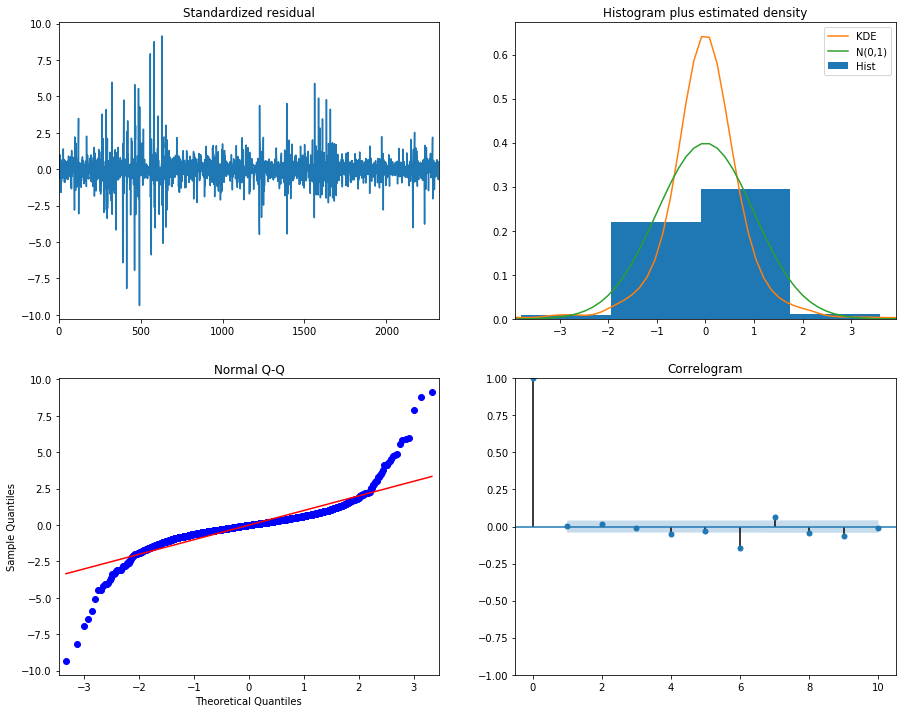

In [262]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [270]:
pred_dynamic = model.get_prediction(start=2423, end=2590, exog=test_factor,
                                    dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [271]:
predict = pred_dynamic.predicted_mean

combine = C841
for t in range(168):
    combine = np.append(combine, combine[t - 168] + predict[t])
    
int1 = startC841
for t in range(2591):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startC84
for t in range(2592):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(2760):
    prediction[2 * i] = int2[i]
    prediction[2 * i + 1] = int2[i]

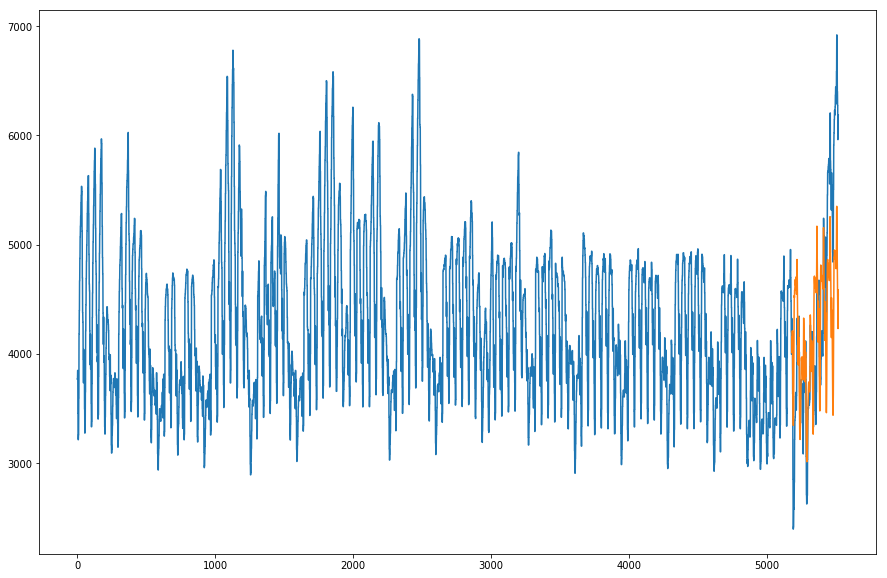

In [272]:
plt.figure(figsize=(15,10))
plt.plot(prediction)
plt.plot(test.Consumption)
plt.show()

In [273]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Consumption)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 663063.69


**True temperature**

In [300]:
train_factor = np.array(train.Temperature)
train_factor = train_factor.reshape(-1, 2)
train_factor = train_factor.mean(axis=-1)
train_factor = train_factor[169:].reshape(-1,1)

test_factor = np.array(test.Temperature)
test_factor = test_factor.reshape(-1, 2)
test_factor = test_factor.mean(axis=-1).reshape(-1,1)

In [276]:
model = sm.tsa.statespace.SARIMAX(C841, order=(1, 1, 2),
                                  seasonal_order=(0, 1, 3, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False,
                                  exog=train_factor)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6138      0.764     -0.804      0.422      -2.111       0.883
ar.L1          0.4562      0.033     13.951      0.000       0.392       0.520
ma.L1         -0.8898      0.240     -3.704      0.000      -1.361      -0.419
ma.L2         -0.1100      0.038     -2.864      0.004      -0.185      -0.035
ma.S.L24      -0.5491      0.010    -56.426      0.000      -0.568      -0.530
ma.S.L48      -0.2067      0.013    -15.862      0.000      -0.232      -0.181
ma.S.L72      -0.2113      0.013    -16.649      0.000      -0.236      -0.186
sigma2      8664.9162   1961.325      4.418      0.000    4820.790    1.25e+04


In [277]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2423
Model:             SARIMAX(1, 1, 2)x(0, 1, 3, 24)   Log Likelihood              -13748.395
Date:                            Fri, 08 Dec 2017   AIC                          27512.791
Time:                                    22:07:00   BIC                          27559.133
Sample:                                         0   HQIC                         27529.642
                                           - 2423                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6138      0.764     -0.804      0.422      -2.111       0.883
ar.L1          0.4562      0.033     13.951      0.000       0.392       0.520
ma.L1         -0.8898      0.240     -3.704      0.000      -1.361      -0.419
ma.L2         -0.1100      0.038     -2.864      0.004      -0.185      -0.035
ma.S.L24      -0.5491      0.010    -56.426      0.000      -0.568      -0.530
ma.S.L48      -0.2067      0.013    -15.862      0.000      -0.232      -0.181
ma.S.L72      -0.2113      0.013    -16.649      0.000      -0.236      -0.186
sigma2      8664.9162   1961.325      4.418      0.000    4820.790    1.25e+04
===================================================================================
Ljung-Box (Q):                      187.17   Jarque-Bera (JB):             33116.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

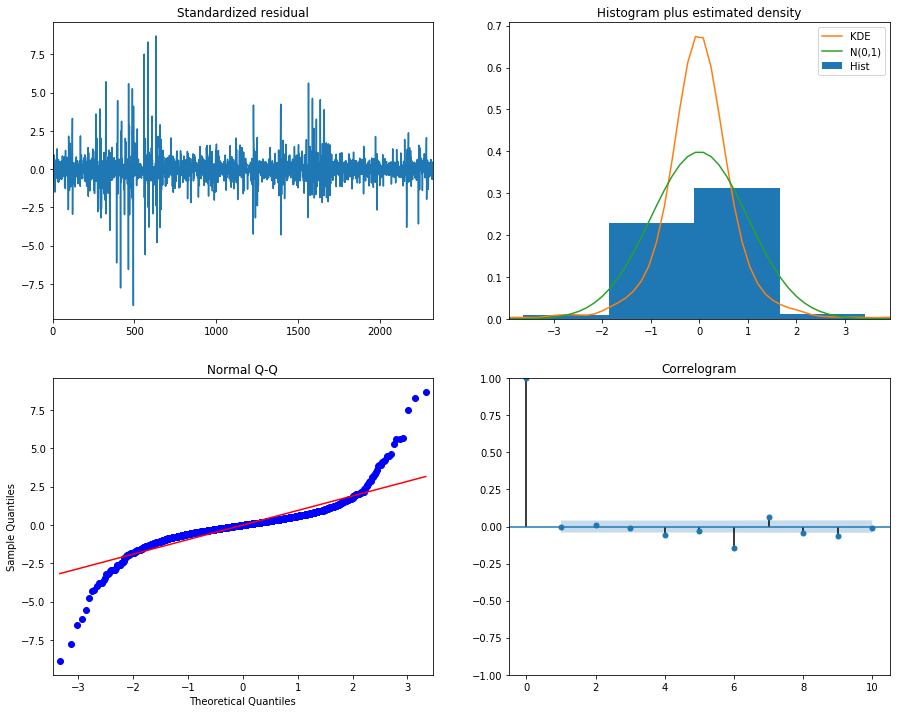

In [278]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [301]:
pred_dynamic = model.get_prediction(start=2423, end=2590, exog=test_factor,
                                    dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [302]:
predict = pred_dynamic.predicted_mean

combine = C841
for t in range(168):
    combine = np.append(combine, combine[t - 168] + predict[t])
    
int1 = startC841
for t in range(2591):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startC84
for t in range(2592):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(2760):
    prediction[2 * i] = int2[i]
    prediction[2 * i + 1] = int2[i]

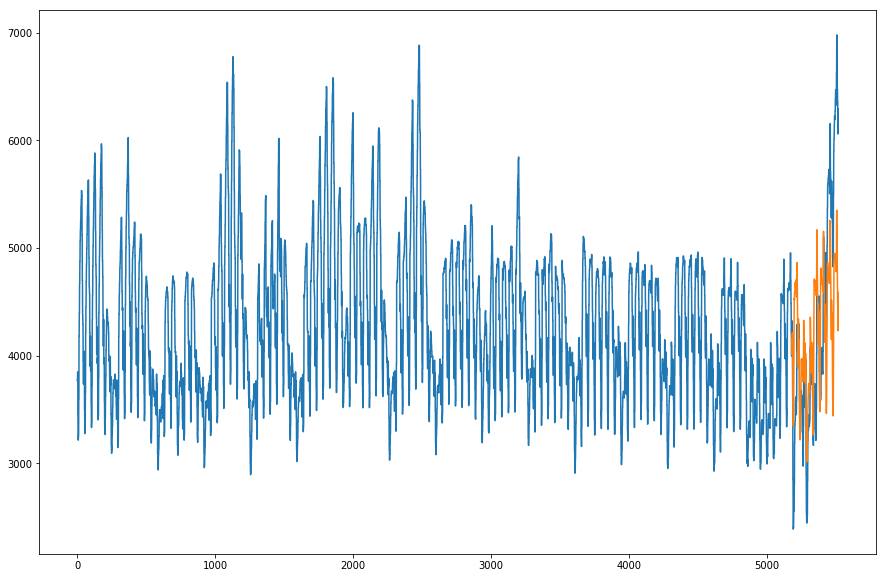

In [303]:
plt.figure(figsize=(15,10))
plt.plot(prediction)
plt.plot(test.Consumption)
plt.show()

In [304]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Consumption)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 712802.5


**Predicted temperature**

In [331]:
train_factor = PREDICTEDTEMPERATURE[:-48*7].reshape(-1, 2)
train_factor = train_factor.mean(axis=-1)
train_factor = train_factor[169:].reshape(-1,1)

test_factor = np.array(test.Temperature)
test_factor = test_factor.reshape(-1, 2)
test_factor = test_factor.mean(axis=-1).reshape(-1,1)

(2423, 1)


In [332]:
model = sm.tsa.statespace.SARIMAX(C841, order=(1, 1, 2),
                                  seasonal_order=(0, 1, 3, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False,
                                  exog=train_factor)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8652      0.706      4.059      0.000       1.482       4.249
ar.L1          0.4473      0.028     16.149      0.000       0.393       0.502
ma.L1         -0.8809      0.070    -12.659      0.000      -1.017      -0.745
ma.L2         -0.1189      0.033     -3.642      0.000      -0.183      -0.055
ma.S.L24      -0.5544      0.009    -58.758      0.000      -0.573      -0.536
ma.S.L48      -0.1973      0.012    -16.609      0.000      -0.221      -0.174
ma.S.L72      -0.2201      0.012    -18.828      0.000      -0.243      -0.197
sigma2      7967.8539    472.509     16.863      0.000    7041.753    8893.955


In [333]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2423
Model:             SARIMAX(1, 1, 2)x(0, 1, 3, 24)   Log Likelihood              -13743.212
Date:                            Fri, 08 Dec 2017   AIC                          27502.425
Time:                                    22:21:45   BIC                          27548.767
Sample:                                         0   HQIC                         27519.276
                                           - 2423                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8652      0.706      4.059      0.000       1.482       4.249
ar.L1          0.4473      0.028     16.149      0.000       0.393       0.502
ma.L1         -0.8809      0.070    -12.659      0.000      -1.017      -0.745
ma.L2         -0.1189      0.033     -3.642      0.000      -0.183      -0.055
ma.S.L24      -0.5544      0.009    -58.758      0.000      -0.573      -0.536
ma.S.L48      -0.1973      0.012    -16.609      0.000      -0.221      -0.174
ma.S.L72      -0.2201      0.012    -18.828      0.000      -0.243      -0.197
sigma2      7967.8539    472.509     16.863      0.000    7041.753    8893.955
===================================================================================
Ljung-Box (Q):                      183.17   Jarque-Bera (JB):             32064.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

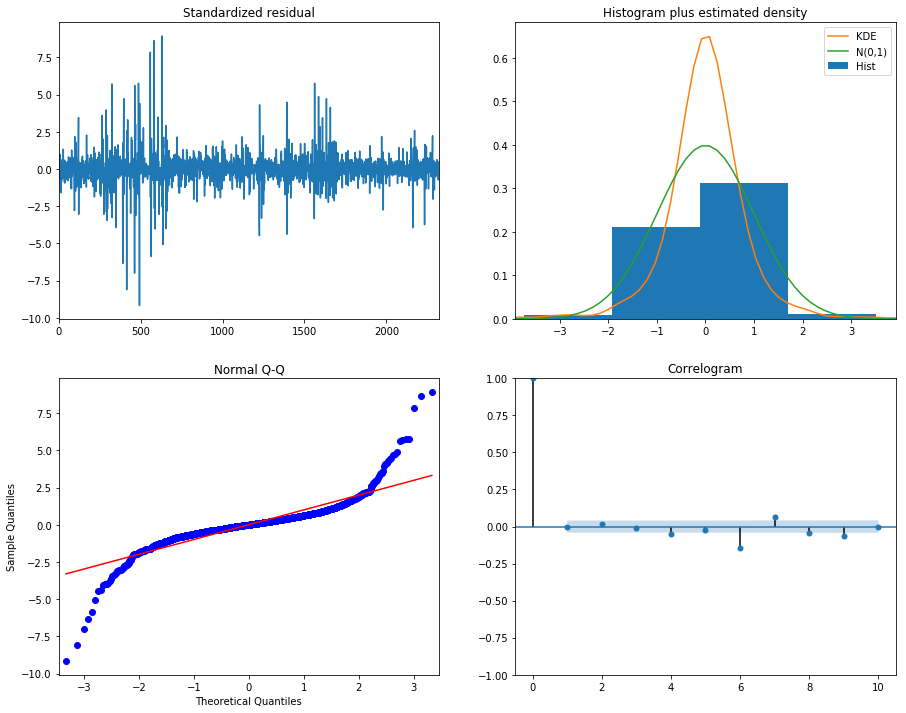

In [334]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [335]:
pred_dynamic = model.get_prediction(start=2423, end=2590, exog=test_factor,
                                    dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [336]:
predict = pred_dynamic.predicted_mean

combine = C841
for t in range(168):
    combine = np.append(combine, combine[t - 168] + predict[t])
    
int1 = startC841
for t in range(2591):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startC84
for t in range(2592):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(2760):
    prediction[2 * i] = int2[i]
    prediction[2 * i + 1] = int2[i]

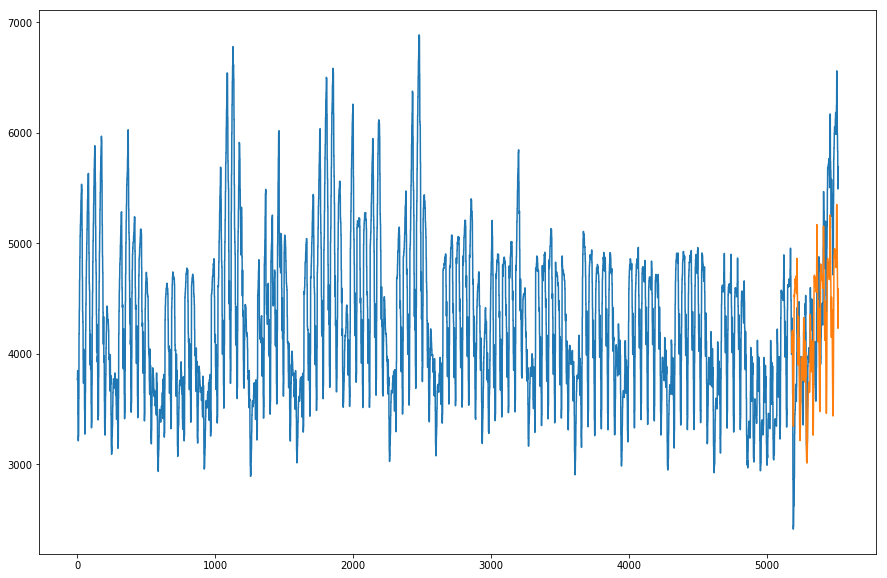

In [337]:
plt.figure(figsize=(15,10))
plt.plot(prediction)
plt.plot(test.Consumption)
plt.show()

In [338]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Consumption)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 536332.28


**Daily seasonality & weekly seasonality & predicted temperature**

In [343]:
train_factor_1 = np.array(train.DailySeasonality)
train_factor_1 = train_factor_1.reshape(-1, 2)
train_factor_1 = train_factor_1.mean(axis=-1)
train_factor_1 = train_factor_1[169:]

train_factor_2 = np.array(train.WeeklySeasonality)
train_factor_2 = train_factor_2.reshape(-1, 2)
train_factor_2 = train_factor_2.mean(axis=-1)
train_factor_2 = train_factor_2[169:]

train_factor_3 = PREDICTEDTEMPERATURE[:-48*7].reshape(-1, 2)
train_factor_3 = train_factor_3.mean(axis=-1)
train_factor_3 = train_factor_3[169:]

test_factor_1 = np.array(test.DailySeasonality)
test_factor_1 = test_factor_1.reshape(-1, 2)
test_factor_1 = test_factor_1.mean(axis=-1)

test_factor_2 = np.array(test.WeeklySeasonality)
test_factor_2 = test_factor_2.reshape(-1, 2)
test_factor_2 = test_factor_2.mean(axis=-1)

test_factor_3 = np.array(test.Temperature)
test_factor_3 = test_factor_3.reshape(-1, 2)
test_factor_3 = test_factor_3.mean(axis=-1)

In [344]:
train_factor = np.vstack((train_factor_1, train_factor_2, train_factor_3)).T
test_factor = np.vstack((test_factor_1, test_factor_2, test_factor_3)).T

In [345]:
model = sm.tsa.statespace.SARIMAX(C841, order=(1, 1, 2),
                                  seasonal_order=(0, 1, 3, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False,
                                  exog=train_factor)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   6382.566   3.59e-08      1.000   -1.25e+04    1.25e+04
x2             0.0108      0.037      0.292      0.771      -0.062       0.083
x3             3.1833      0.709      4.491      0.000       1.794       4.573
ar.L1          0.4480      0.028     15.920      0.000       0.393       0.503
ma.L1         -0.8866      0.071    -12.424      0.000      -1.026      -0.747
ma.L2         -0.1132      0.033     -3.427      0.001      -0.178      -0.048
ma.S.L24      -0.5822      0.016    -35.314      0.000      -0.614      -0.550
ma.S.L48      -0.2184      0.014    -16.140      0.000      -0.245      -0.192
ma.S.L72      -0.2198      0.010    -21.323      0.000      -0.240      -0.200
sigma2      7808.1733    507.564     15.384      0.000    6813.365    8802.981


In [346]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2423
Model:             SARIMAX(1, 1, 2)x(0, 1, 3, 24)   Log Likelihood              -13744.111
Date:                            Fri, 08 Dec 2017   AIC                          27508.223
Time:                                    22:34:00   BIC                          27566.150
Sample:                                         0   HQIC                         27529.287
                                           - 2423                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   6382.566   3.59e-08      1.000   -1.25e+04    1.25e+04
x2             0.0108      0.037      0.292      0.771      -0.062       0.083
x3             3.1833      0.709      4.491      0.000       1.794       4.573
ar.L1          0.4480      0.028     15.920      0.000       0.393       0.503
ma.L1         -0.8866      0.071    -12.424      0.000      -1.026      -0.747
ma.L2         -0.1132      0.033     -3.427      0.001      -0.178      -0.048
ma.S.L24      -0.5822      0.016    -35.314      0.000      -0.614      -0.550
ma.S.L48      -0.2184      0.014    -16.140      0.000      -0.245      -0.192
ma.S.L72      -0.2198      0.010    -21.323      0.000      -0.240      -0.200
sigma2      7808.1733    507.564     15.384      0.000    6813.365    8802.981
===================================================================================
Ljung-Box (Q):                      183.25   Jarque-Bera (JB):             32118.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

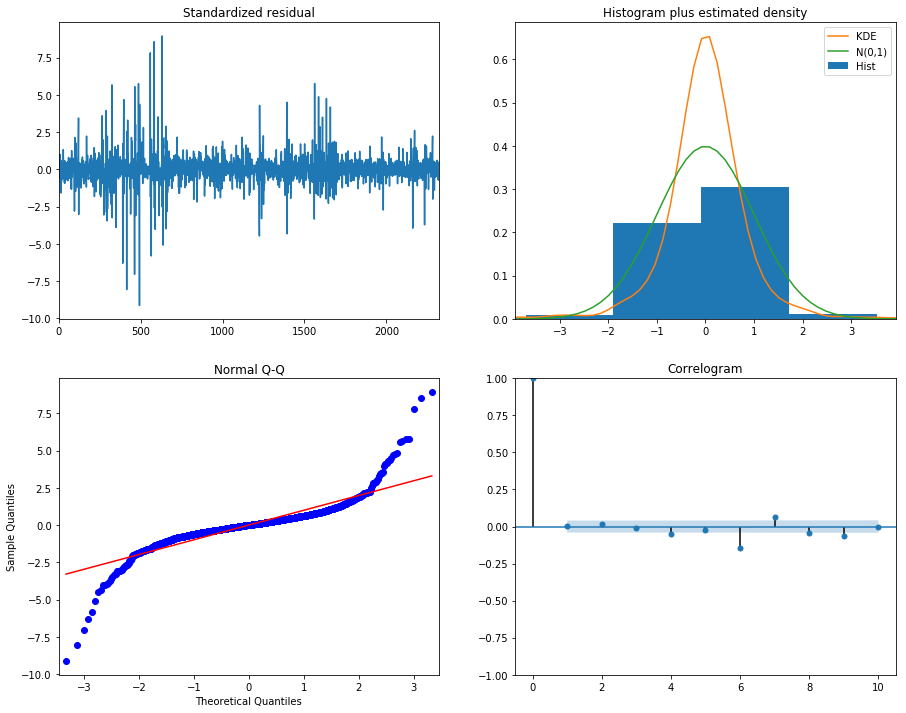

In [347]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [348]:
pred_dynamic = model.get_prediction(start=2423, end=2590, exog=test_factor,
                                    dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [349]:
predict = pred_dynamic.predicted_mean

combine = C841
for t in range(168):
    combine = np.append(combine, combine[t - 168] + predict[t])
    
int1 = startC841
for t in range(2591):
    int1 = np.append(int1, combine[t] + int1[t])
    
int2 = startC84
for t in range(2592):
    int2 = np.append(int2, int1[t] + int2[t])

prediction = np.zeros(5520)
for i in range(2760):
    prediction[2 * i] = int2[i]
    prediction[2 * i + 1] = int2[i]

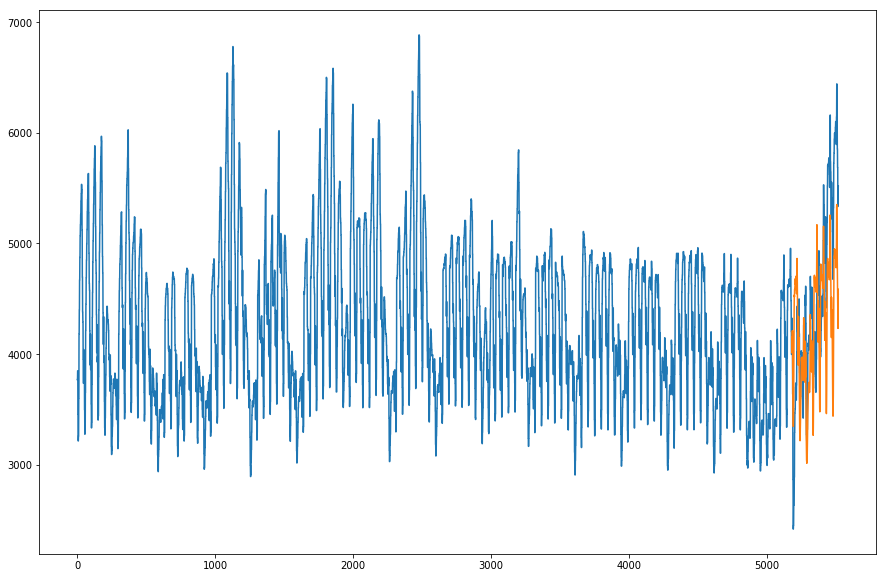

In [350]:
plt.figure(figsize=(15,10))
plt.plot(prediction)
plt.plot(test.Consumption)
plt.show()

In [351]:
check = prediction[-336:]
mse = ((prediction[-336:] - np.array(test.Consumption)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 520419.22


Сравним все предскзаания по метрике $MSE$.

In [396]:
print('Without regressors\t', 650602.58)
print('Daily seasonality & weekly seasonality\t', 663063.69)
print('True temperature\t', 712802.5)
print('Predicted temperature\t', 536332.28)
print('Daily seasonality & weekly seasonality & predicted temperature\t', 520419.22)

Without regressors	 650602.58
Daily seasonality & weekly seasonality	 663063.69
True temperature	 712802.5
Predicted temperature	 536332.28
Daily seasonality & weekly seasonality & predicted temperature	 520419.22


**Выводы:** 
* Видим, что в последнем случае ошибка получилась наименьшей. То есть регрессоры могут помочь нам сделать запрос точнее.
* Объясним, зачем надо было усреднять выборку:
    * Посмотрев на то, что выводится в терминале, когда происходит $fit$ и почитав форумы, я пришел к выводу, что 'под капотом' функции находится что-то вроде задачи линейного программирования и решается она черзе метод наименьших квадратов. Работать с матрицами размера ~(5000 x 5000) тяжело: может не хватить оперативной памяти, или это займет очень большое число времени (сначала я считал на исходных данных, на подбор оптимальных параметров для температуры ушло около 15 часов). После того, как данные усреднили все стало быстрее - это естественно, ведь мы уменьшили объем обрабатываемых данных. 

BLANKBLANKBLANK

HERE

In [402]:
print('THERE')

THERE


In [403]:
print('ALMOST')

ALMOST


FINISHED